In [32]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

In [2]:
!gdown --id 1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV

Downloading...
From: https://drive.google.com/uc?id=1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV
To: /content/storage_sample_stage4.h5
100% 103M/103M [00:01<00:00, 54.1MB/s]


In [3]:
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [4]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [6]:
train_graph=nx.read_edgelist('/content/drive/MyDrive/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

DiGraph with 1780722 nodes and 7550015 edges


In [7]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return  num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees

In [8]:
a,b,num_followers_d,c,d,e=compute_features_stage1(df_final_train)

In [9]:
df_final_train['num_followers_d']=num_followers_d

In [10]:
a,b,num_followers_d,c,d,e=compute_features_stage1(df_final_test)
df_final_test['num_followers_d']=num_followers_d

In [12]:
def pref_attach(df):
  pref_attach=[]
  for i in range(len(df)):
    pref_attach.append(df['num_followers_s'][i]*df['num_followers_d'][i])
  return pref_attach  

In [13]:
df_final_train['pref_attach']=pref_attach(df_final_train)
df_final_test['pref_attach']=pref_attach(df_final_test)

In [16]:
def svd_dot(df):
  svd_dot_u=[]
  svd_dot_v=[]
  for i in range(len(df)):
    svd_dot_u.append(np.dot(df[[ 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6']].values[i],df[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']].values[i]))
    svd_dot_v.append(np.dot(df[['svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']].values[i],df[['svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']].values[i]))
  return svd_dot_u,svd_dot_v  

In [19]:
df_final_train['svd_dot_u'],df_final_train['svd_dot_v']=svd_dot(df_final_train)
df_final_test['svd_dot_u'],df_final_test['svd_dot_v']=svd_dot(df_final_test)

In [20]:
print(df_final_train.columns,df_final_test.columns)

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d', 'pref_attach', 'svd_dot_u', 'svd_dot_v'],
      dtype='object') Index(['source_node', 'destination_node',

In [23]:
y_tr=df_final_train['indicator_link']
y_te=df_final_test['indicator_link']
x_tr=df_final_train.drop(['source_node','destination_node','indicator_link'],axis=1)
x_te=df_final_test.drop(['source_node','destination_node','indicator_link'],axis=1)

In [25]:
params={'max_depth':[2,4,6,8,10],'n_estimators':[10,15,20,25,30]}
clf=xgb.XGBClassifier(random_state=1)
gs=GridSearchCV(clf,params,n_jobs=-1,scoring='f1')
gs.fit(x_tr,y_tr)
best_clf=gs.best_estimator_
print('Best Params are :',gs.best_params_)
print('Best f1 score =',gs.best_score_)

Best Params are : {'max_depth': 10, 'n_estimators': 30}
Best f1 score = 0.9756753027849957


In [26]:
best_clf.fit(x_tr,y_tr)
y_tr_pred=best_clf.predict(x_tr)
y_te_pred=best_clf.predict(x_te)

In [28]:
print('Train f1 score',f1_score(y_tr,y_tr_pred))
print('Test f1 score',f1_score(y_te,y_te_pred))

Train f1 score 0.9802911375781637
Test f1 score 0.9340082252451755


In [29]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


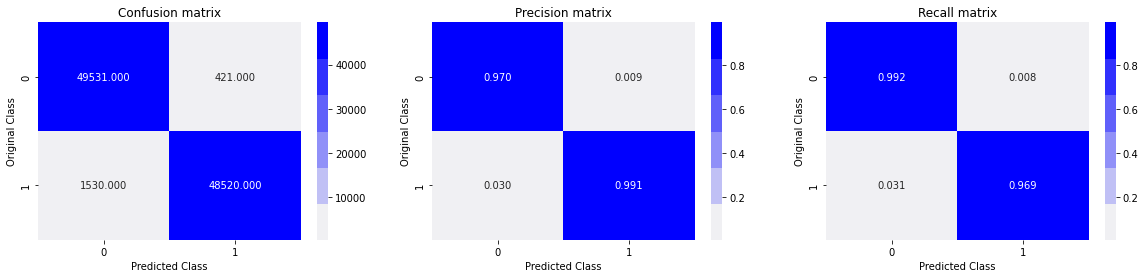

Test confusion_matrix


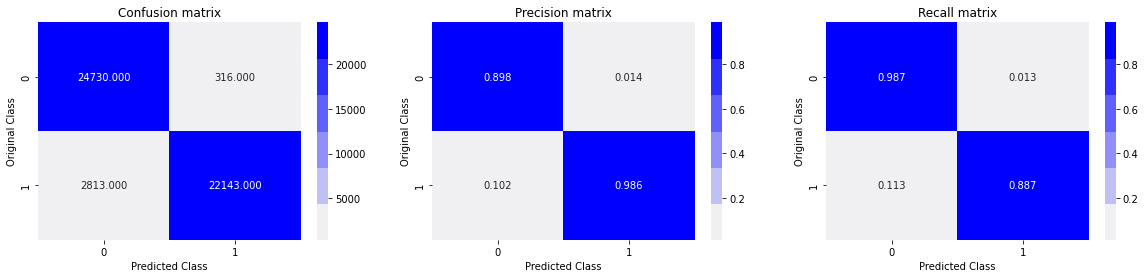

In [30]:
print('Train confusion_matrix')
plot_confusion_matrix(y_tr,y_tr_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_te,y_te_pred)

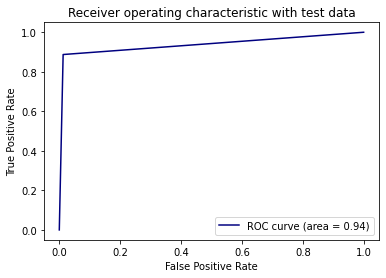

In [33]:
fpr,tpr,ths = roc_curve(y_te,y_te_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

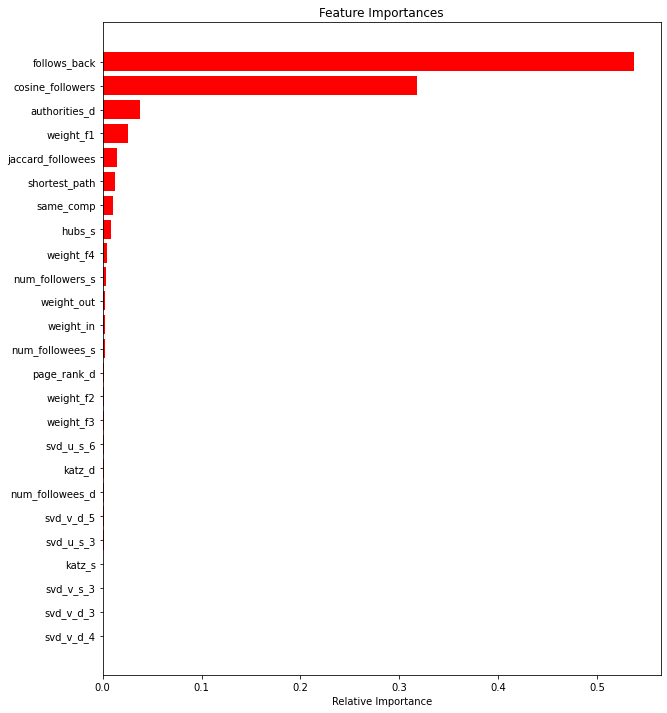

In [35]:
features = x_tr.columns
importances = best_clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# **Conclusion:**

1. First I loaded the important libraries and data.
2. Then I noticed num_followers_d feature was missing in the train and test dataframe.
3. Then I evaluated and added that feature in thr dataset using the graph.
4. Another reason of adding num_followers_d was to evaluate feature preferential attachment that is the multiplication of followers of source and destination node.
5. After evalauating and adding preferential attachment feature in the dataset, I evaluated SVD Dot features which are the dot product of components of right singular matrix of source and destination node named as svd_dot_u and dot product of components of left singular matrix of source and destination named as svd_dot_v.
6. After evaluating and adding both the features in the dataset, I tuned the hyperparameters of XGBoost Classifier using Grid Search.
7. After getting the best classifier, I fitted the model and calculated f1 score, confusion matrix and roc curve.